In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylib.style as pys
import os.path

%matplotlib inline

## Получаю данные

In [2]:
SEASON = 19

In [3]:
df_signal = pd.read_csv(f'../data/{SEASON}/results/signal.csv', index_col=0)
df_reg_eff = pd.read_csv(f'../data/{SEASON}/results/reg_eff.csv', index_col=0)
df_triggers = pd.read_csv(f'../data/{SEASON}/results/triggers.csv', index_col=0)
df_lum = pd.read_csv(f'/storeA/ryzhenenkov/lum20{SEASON}.dat', sep='\t', names=['energy', 'lum', 'lum_err'], index_col='energy')

In [4]:
df = pd.concat([df_signal, df_reg_eff, df_triggers, df_lum], axis=1)

Определяю проблемные точки, пока удаляю их, но нужно присмотреться

In [5]:
df.loc[np.any(df.isna(), axis=1)]

,n_sig_exp,n_bkg_exp,m_exp,sL_exp,sR_exp,aL_exp,aR_exp,k_exp,n_sig_exp_err,n_bkg_exp_err,...,CF,TC,effT,effC,effT_err,effC_err,eff_trig,eff_trig_err,lum,lum_err
550.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,496.833,1.14065
612.5,187.720811,31.279226,-0.142439,2.40781,2.439979,0.089821,0.156136,0.068587,12.213822,8.420231,...,7.0,196.0,0.960976,0.920561,0.013492,0.018443,0.9969,0.001291,1059.040,1.86299
612.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1179.140,1.96537


In [6]:
df.dropna(inplace=True)

## Определить радпоправки

In [66]:
def calc_cs_born(df):
    cs_born = df['n_sig_exp']/(df['lum']*df['eff0']*df['eff_trig']*df['rad'])
    cs_born_err = cs_born*np.sqrt( (df['n_sig_exp_err']/df['n_sig_exp'])**2 +
        (df['lum_err']/df['lum'])**2 + (df['eff0_err']/df['eff0'])**2 + (df['eff_trig_err']/df['eff_trig'])**2)
    return (cs_born, cs_born_err)

In [34]:
from pylib.csapprox import MDVM
from iminuit import Minuit, cost

In [35]:
mdvm = MDVM()

In [210]:
FILE_RADCOR = '../data/19/results/radcors.csv'
df_rads = pd.read_csv(FILE_RADCOR, index_col=0) if os.path.isfile(FILE_RADCOR) else pd.DataFrame({'rad': 1, 'rad_err': 0}, index=df.index)

In [211]:
df_rads.head()

,rad,rad_errs
537.5,0.895741,3.249332e-07
550.0,0.891109,1.284712e-05
550.1,0.896816,3.892619e-05
562.5,0.903311,7.534962e-05
575.0,0.904306,7.121021e-07


In [212]:
df2 = df.join(df_rads)
df_koz = pd.read_csv('../data/other/kskl_kozyrev.txt').rename({'E': 'emeas', 'cs': 'cs_born', 'cs_err': 'cs_born_err'}, axis=1)
df_koz['emeas'] /= 2
df2['cs_born'], df2['cs_born_err'] = calc_cs_born(df2)
df2 = pd.concat([df_koz, df2[['emeas', 'rad', 'cs_born', 'cs_born_err']]])

In [213]:
df2.head()

,emeas,rad,cs_born,cs_born_err
0.0,502.0330,0.72,6.87,0.42
1.0,505.2330,0.73,42.16,0.47
2.0,506.4775,0.72,96.74,1.00
3.0,507.5340,0.71,219.53,5.02
4.0,508.0525,0.71,366.33,3.33


In [214]:
params = [0.9639, 1.0919, -0.0062, -0.0279, 1.0509, 
          -0.0674, 1740.0, 250.0, 1670.0, 315.0, 1680.0, 
          150.0, 2150.0, 315.0, 1470.0, 400.0, 1425.0, 
          225.0, 2239.0, 139.0, 1.3856, 0.0064, -0.2363, 0.01]

In [215]:
m = Minuit(cost.LeastSquares(df2.emeas*2e-3, 
        df2.cs_born, df2.cs_born_err, lambda x, n, r1, r2, r3, p1, p2, mr3, wr3, mo2, wo2, mp1, wp1, mo3, wo3, mr1, wr1, mo1, wo1, a18, a19, a20, a21, a22, a23: 
        mdvm.Cross_Section_Neutral(x, [n, r1, r2, r3, p1, p2, mr3, wr3, mo2, wo2, mp1, wp1, mo3, wo3, mr1, wr1, mo1, wo1, a18, a19, a20, a21, a22, a23])), *params)

In [216]:
m.fixed['mr3'], m.fixed['wr3'] = True, True
m.fixed['mo2'], m.fixed['wo2'] = True, True
m.fixed['mp1'], m.fixed['wp1'] = True, True
m.fixed['mo3'], m.fixed['wo3'] = True, True
m.fixed['mr1'], m.fixed['wr1'] = True, True
m.fixed['mo1'], m.fixed['wo1'] = True, True

In [221]:
m.simplex()#.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 128.5                      │             Nfcn = 4558              │
│ EDM = 0.0714 (Goal: 0.1)         │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│ NO Covariance │     Hesse ok     │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n    │ 919.8e-3  │  0.8e-3   │            │            │         │         │       │
│ 1 │ r1   │  1.1581   │  0.0004   │            │            │         │         │       │
│ 2 │ r2   │ -214.1e-3 │  0.6e-3   │            │            │         │         │       │
│ 3 │ r3   │ -1.83e-3  │  0.18e-3  │            │            │         │         │       │
│ 4 │ p1   │  1.1132   │  0.0010   │            │            │         │         │       │
│ 5 │ p2   │-139.93e-3 │  0.23e-3  │            │            │         │         │       │
│ 6 │ mr3  │  1.740e3  │  0.017e3  │            │            │         │         │  yes  │
│ 7 │ wr3  │   250.0   │    2.5    │            │            │         │         │  yes  │
│ 8 │ mo2  │  1.670e3  │  0.017e3  │            │            │         │         │  yes  │
│ 9 │ wo2  │   315.0   │    3.2    │            │            │         │         │  yes  │
│ 10│ mp1  │  1.680e3  │  0.017e3  │            │            │         │         │  yes  │
│ 11│ wp1  │   150.0   │    1.5    │            │            │         │         │  yes  │
│ 12│ mo3  │  2.150e3  │  0.021e3  │            │            │         │         │  yes  │
│ 13│ wo3  │   315.0   │    3.2    │            │            │         │         │  yes  │
│ 14│ mr1  │  1.470e3  │  0.015e3  │            │            │         │         │  yes  │
│ 15│ wr1  │    400    │     4     │            │            │         │         │  yes  │
│ 16│ mo1  │  1.425e3  │  0.014e3  │            │            │         │         │  yes  │
│ 17│ wo1  │   225.0   │    2.3    │            │            │         │         │  yes  │
│ 18│ a18  │ 2.2759e3  │ 0.0008e3  │            │            │         │         │       │
│ 19│ a19  │    507    │     4     │            │            │         │         │       │
│ 20│ a20  │  1.5102   │  0.0024   │            │            │         │         │       │
│ 21│ a21  │  -0.3865  │  0.0011   │            │            │         │         │       │
│ 22│ a22  │  0.1091   │  0.0015   │            │            │         │         │       │
│ 23│ a23  │   1.033   │   0.007   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

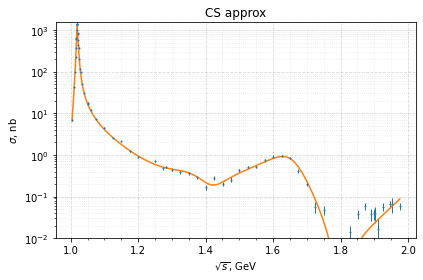

In [222]:
xx = np.linspace(df2.emeas.min()*2e-3, df2.emeas.max()*2e-3, 200)
yy = mdvm.Cross_Section_Neutral(xx, m.values)

plt.errorbar(df2.emeas*2e-3, df2.cs_born, yerr=df2.cs_born_err, fmt='.', label=f'Measured cs', alpha=1, markersize=2, lw=1)
plt.plot(xx, yy)
pys.my_style(title='CS approx', xtitle='$\sqrt{s}$, GeV', ytitle='$\sigma$, nb',
            ylim=(1e-2, None))
plt.yscale('log')

In [223]:
df_fit = pd.DataFrame({'emeas': xx, 'cs_born': yy})

In [224]:
from pylib.radcors import RadCor
from pylib.regeff import RegEff

In [225]:
r = RadCor(df_fit.emeas*0.5e3, df_fit.cs_born)

In [226]:
ens, rads, rads_errs = [], [], []
for i, j in df_reg_eff.iterrows():
    rad, rad_err = r.F_Radcor(i, j[:4])/RegEff.sigFunc(0, *j[:4])
    ens.append(i)
    rads.append(rad)
    rads_errs.append(rad_err)
ser_rads = pd.Series(rads, index=ens, name='rad')
ser_rads_errs = pd.Series(rads_errs, index=ens, name='rad_errs')

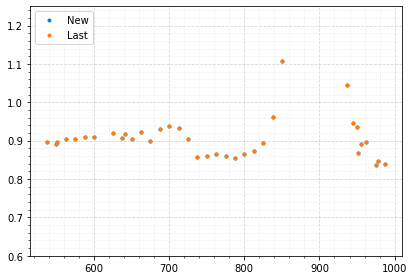

In [231]:
plt.errorbar(ens, rads, fmt='.', label='New')
plt.errorbar(df_rads.index, df_rads.rad, fmt='.', label='Last')
plt.legend()
pys.my_style()
plt.ylim(0.6, 1.25);

In [232]:
df_rads = pd.DataFrame([ser_rads, ser_rads_errs]).T

In [233]:
df_rads.to_csv(FILE_RADCOR)

## Рисовать сечения

In [235]:
df_signal = pd.read_csv(f'../data/{SEASON}/results/signal.csv', index_col=0)
df_reg_eff = pd.read_csv(f'../data/{SEASON}/results/reg_eff.csv', index_col=0)
df_triggers = pd.read_csv(f'../data/{SEASON}/results/triggers.csv', index_col=0)
df_lum = pd.read_csv(f'/storeA/ryzhenenkov/lum20{SEASON}.dat', sep='\t', names=['energy', 'lum', 'lum_err'], index_col='energy')
df_rads = pd.read_csv(f'../data/{SEASON}/results/radcors.csv', index_col=0)

In [246]:
df = pd.concat([df_signal, df_reg_eff, df_triggers, df_lum, df_rads], axis=1).dropna()
df['cs_born'], df['cs_born_err'] = calc_cs_born(df)

In [266]:
df2 = pd.read_csv('images/res12_new.csv', index_col=0)
df2['cs_born'] = df2['n_sig_exp']/(df2['lum']*df2['eff_reg']*df2['eff_trig']*df2['rad'])
df2['cs_born_err'] = df2['cs_born']*np.sqrt( (df2['n_sig_exp_err']/df2['n_sig_exp'])**2 +
        (df2['lum_err']/df2['lum'])**2 + (df2['eff_reg_err']/df2['eff_reg'])**2 + (df2['eff_trig_err']/df2['eff_trig'])**2)

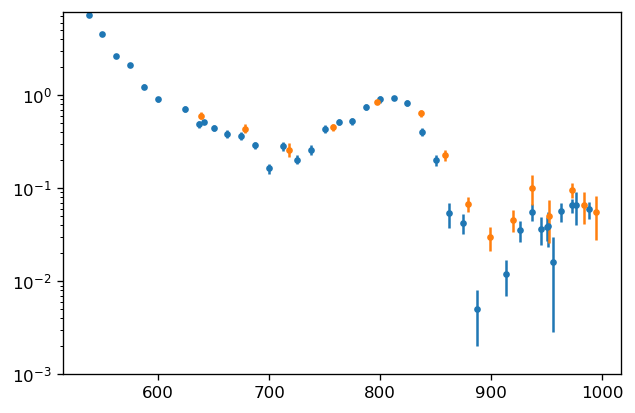

In [267]:
plt.figure(dpi=120)
plt.errorbar(df.emeas, df.cs_born, yerr=df.cs_born_err, fmt='.')
plt.errorbar(df2.emeas, df2.cs_born, yerr=df2.cs_born_err, fmt='.')
plt.ylim(1e-3, None)
plt.yscale('log')